In [56]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import scipy
from scipy import stats
from shapely import wkt

from tqdm import tqdm 

import child_poverty_iraq.data.load_data as ld
import child_poverty_iraq.utils.constants as c
import child_poverty_iraq.models.train_model as tm
import child_poverty_iraq.models.evaluate_model as em


In [2]:
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Use functions defined in train_model

## PCA

In [14]:
import child_poverty_iraq.models.train_model as tm
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



In [3]:
merged = pd.read_csv('../data/processed/20230918_adm1_mosaiks_pov_merged.csv')
merged.shape

(1033, 4031)

In [4]:
target = 'deprived_mod'

boxcox=True
weight = 1

In [6]:
# Clean target
data = tm.clean_target(merged, target)

# Boxcox
if boxcox:
    data, lmbda = tm.transform_boxcox(data, target, plot=False)
    target_t = f"{target}_bc"
else:
    target_t = target

merged_train, merged_test = tm.split_train_test(data, target_t)
X_train, y_train = merged_train[c.mosaiks_features], merged_train[target]
X_test, y_test = merged_test[c.mosaiks_features], merged_test[target]

# Define weights (if weight = 1, there is no weighting)
sample_weights = tm.define_sample_weights(
    merged_train, countrycode="IRQ", weight=weight
)


scaler = tm.get_standard_scaler(X_train)
X_train_scaled = scaler.transform(X_train)

In [12]:
n_components = [50, 75, 100, 150, 200, 300, 400, 500, 600, 700, 800]
n_components

[50, 75, 100, 150, 200, 300, 400, 500, 600, 700, 800]

In [56]:
explained_variances = []

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(X_train_scaled)    
    explained_variances.append(sum(pca.explained_variance_ratio_))


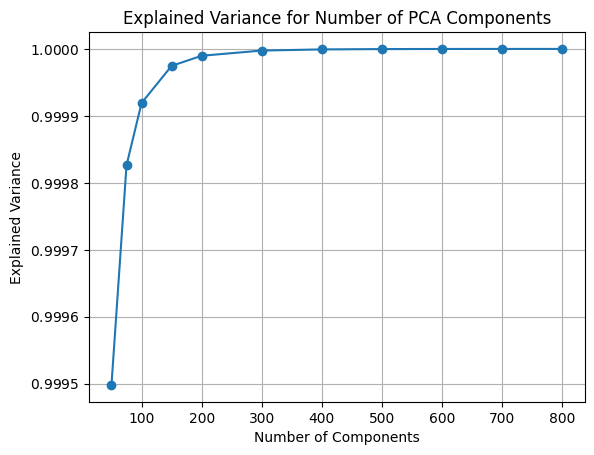

In [57]:
# Plot the explained variance as a function of the number of components
plt.plot(n_components, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance for Number of PCA Components')
plt.grid()

# Format the y-axis tick labels to display in long form
plt.gca().get_yaxis().set_major_formatter(plt.ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='plain', useOffset=False)


plt.show()

In [7]:
n_components_chosen = 300

## Weights

In [ ]:
results_train, results_test = tm.train_model(merged, target="deprived_mod", boxcox=True, pca_components=300, weight=1, plot=False)


In [23]:
n_weights = [1, 5, 10, 15, 20, 25, 30, 50, 100, 200]

In [24]:
r2_cv = []
r2_cv_sd = []
r2_train =[]
r2_test = []

for i in tqdm(n_weights):
    results_train, results_test = tm.train_model(merged, target="deprived_mod", boxcox=True, pca_components=n_components_chosen, weight=i, plot=False)
    r2_cv.append(results_train['r2_cv'])
    r2_cv_sd.append(results_train['r2_cv_sd'])
    r2_train.append(results_train['r2_train'])
    r2_test.append(results_test['r2_test'])

100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


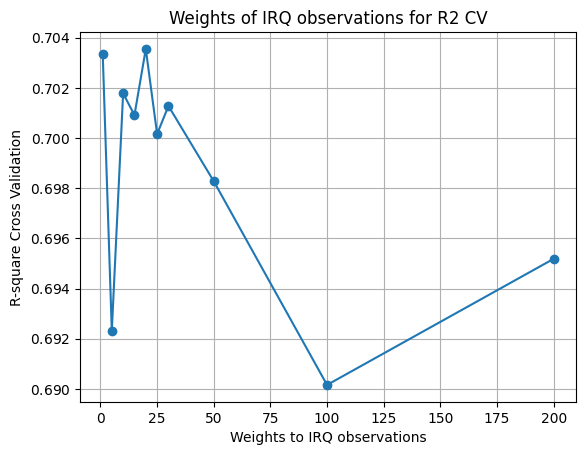

In [26]:
# Plot the explained variance as a function of the number of components
plt.plot(n_weights, r2_test, marker='o')
plt.xlabel('Weights to IRQ observations')
plt.ylabel('R-square Cross Validation')
plt.title('Weights of IRQ observations for R2 CV')
plt.grid()

# Format the y-axis tick labels to display in long form
plt.gca().get_yaxis().set_major_formatter(plt.ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(axis='y', style='plain', useOffset=False)


plt.show()

## Model

In [60]:
target = 'deprived_mod'

In [4]:
merged = pd.read_csv('../data/processed/20230918_adm1_mosaiks_pov_merged.csv')
merged.shape

(1033, 4031)

In [61]:
merged_m, model, results = tm.train_model(merged, target=target, 
                                   model = Ridge(1),
                                   boxcox=False, pca_components=None, weight=10, plot=False)

print(results)

y_train_pred = merged_m[merged_m['is_training']==1]['predictions']
y_train = merged_m[merged_m['is_training']==1][target]
y_test_pred = merged_m[merged_m['is_training']==0]['predictions']
y_test = merged_m[merged_m['is_training']==0][target]


{'r2_cv': 0.4051953326504054, 'r2_cv_sd': 0.1405836105918421, 'r2_train': 0.9027019889171716, 'r2_test': 0.6847308394256494}


/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


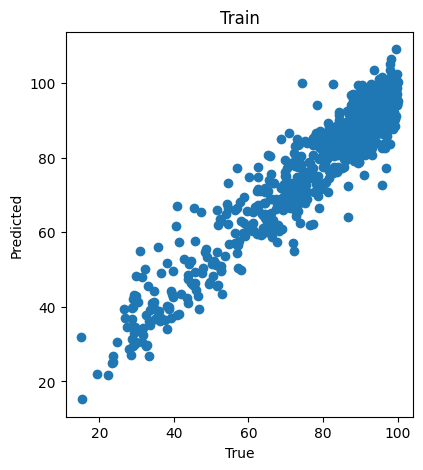

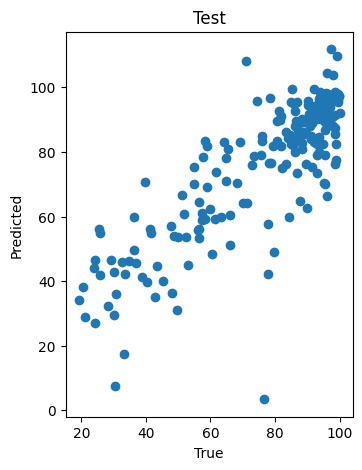

In [63]:
em.scatter_plot(y_train_pred, y_train, y_test, y_test_pred)

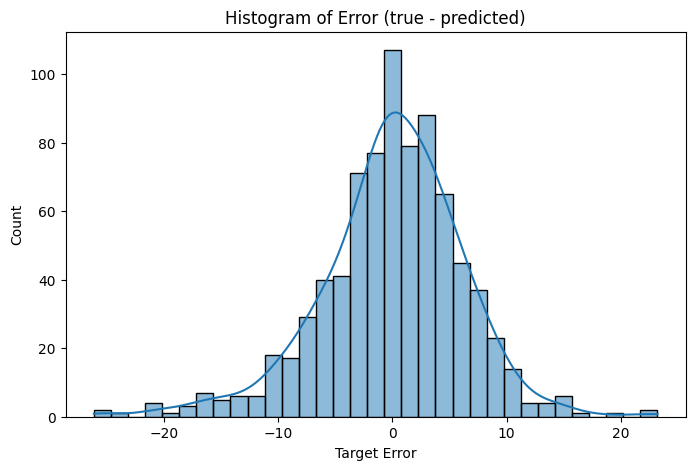

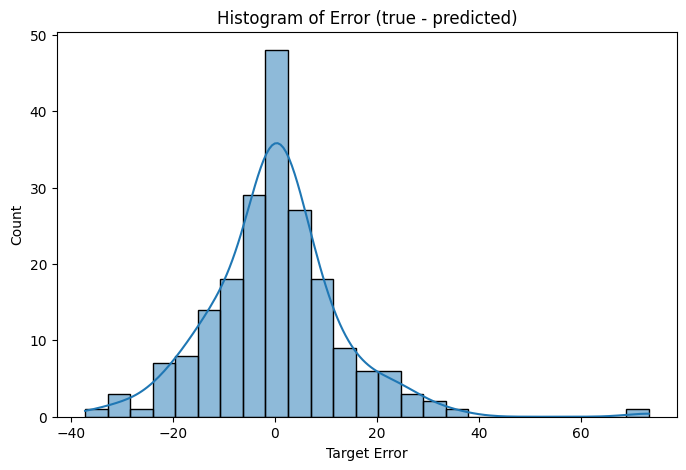

In [64]:
em.hist_errors(y_train_pred, y_train, y_test, y_test_pred)


The file '../data/external/geoBoundariesCGAZ_ADM0.topojson' exists.


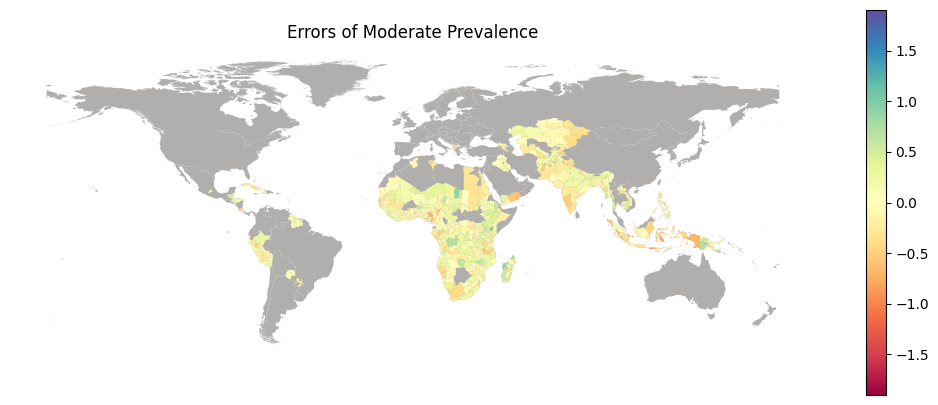

In [59]:
em.map_errors(merged_m, col_to_plot="target_error")


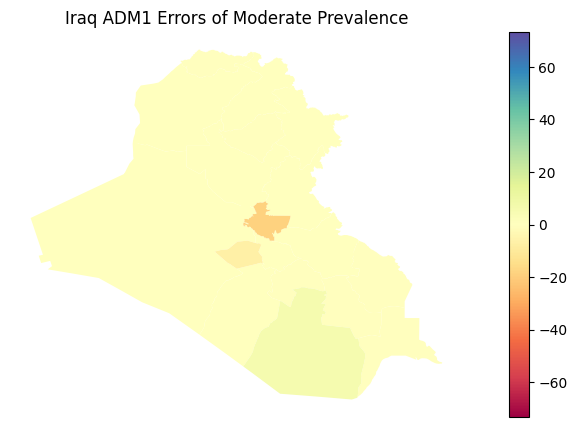

In [65]:
em.map_irq_error(merged_m, col_to_plot="target_error")


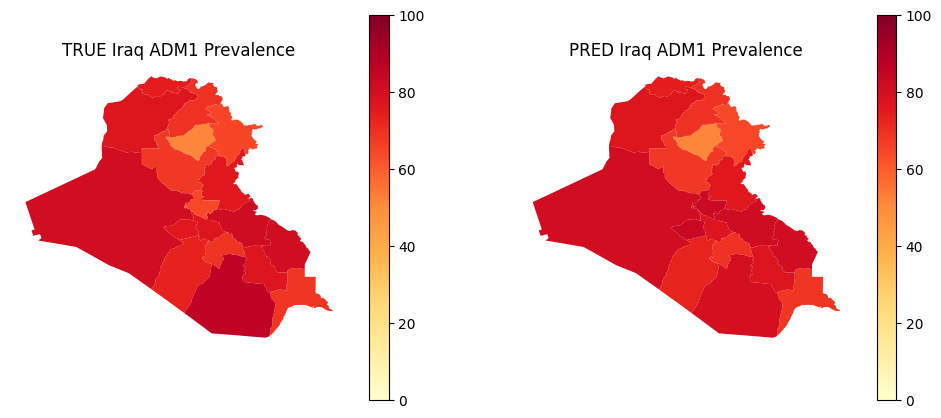

In [66]:
em.compare_irq_pred(merged_m, target, cmap="YlOrRd")

In [70]:
def map_irq_training(data):
    # Create a plot using matplotlib
    fig, ax = plt.subplots(figsize=(12, 5))  # , dpi=200)

    # Plot countries with ADM1 error poverty estimates
    data[data["countrycode"] == "IRQ"].plot(
        ax=ax,
        column='is_training',
        cmap="PiYG",
        legend=True
    )

    plt.title("Iraq ADM1 Errors of Moderate Prevalence")
    plt.axis("off")
    plt.show()


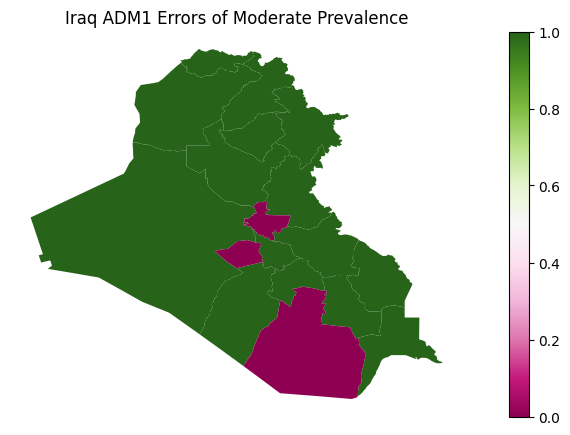

In [71]:
map_irq_training(merged_m)

# Load data

In [ ]:
mosaiks_adm1 = ld.get_mosaiks_adm1()
pov_adm1 = ld.get_poverty_adm1()

In [ ]:
merged = ld.merge_mosaiks_pov_adm1(pov_adm1, mosaiks_adm1, threshold=0.51)

In [ ]:
merged.shape

In [ ]:
# merged.drop(columns=['geom_pov', 'geom_mos', 'geom_inter']).to_csv('../data/processed/20230918_adm1_mosaiks_pov_merged.csv', index=False)

In [ ]:
# merged = pd.read_csv('../data/processed/20230918_adm1_mosaiks_pov_merged.csv')
# merged.shape

In [ ]:
irq_adm2 = ld.adm2_for_country(cc='IRQ')

In [ ]:
irq_01x01 = pd.read_csv('../data/interim/mosaiks_irq_01x01.csv')
print(irq_01x01.shape)
irq_01x01.head(2)

In [ ]:
# Create a geometry column with Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(irq_01x01['lon'], irq_01x01['lat'])]

# Create a GeoDataFrame from the DataFrame and geometry
irq_01x01 = gpd.GeoDataFrame(irq_01x01, geometry=geometry, crs='EPSG:4326')  # Assuming WGS 84 coordinate reference system


# Target

In [3]:
target = 'deprived_mod'

In [8]:
print(merged[target].isna().sum())

merged_clean = merged[merged[target].isna()==False].copy()
print(merged_clean.shape)

27
(1006, 4031)


# EDA

Text(0.5, 1.0, 'ADM1 Moderate Prevalence')

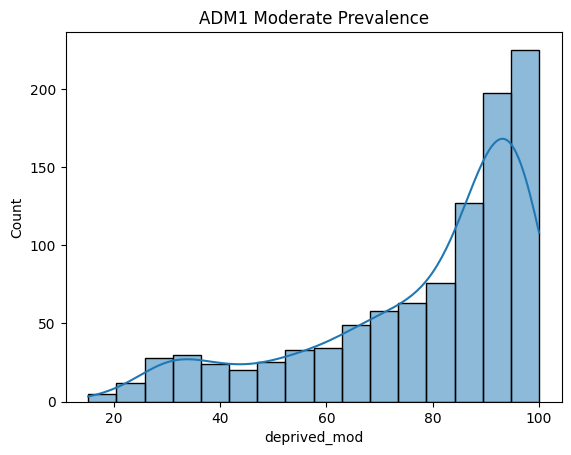

In [7]:
sns.histplot(merged['deprived_mod'], kde=True)
plt.title('ADM1 Moderate Prevalence')

In [10]:
# # Demean approach
# merged['deprived_mod_demean'] = merged['deprived_mod'] - merged['nat_deprived_mod']
# merged['deprived_mod_demean'].hist()

Text(0.5, 1.0, 'Logarithm')

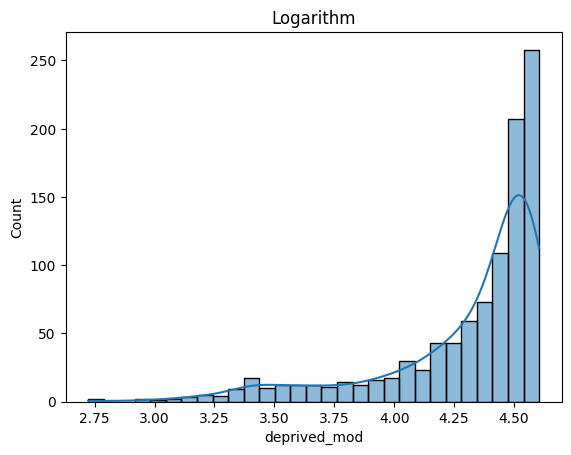

In [7]:
sns.histplot(np.log(merged['deprived_mod']), kde=True)
plt.title('Logarithm')

Text(0.5, 1.0, 'Square root')

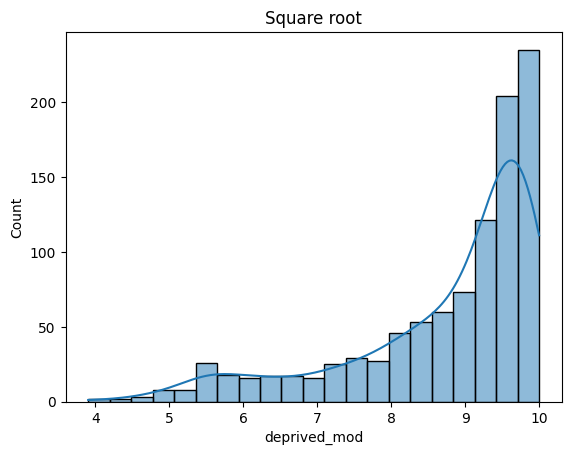

In [8]:
sns.histplot(np.sqrt(merged['deprived_mod']), kde=True)
plt.title('Square root')

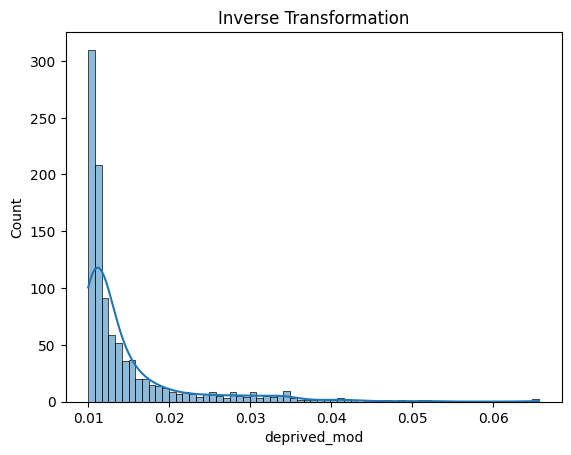

In [12]:
# Inverse transformation
inverse_transformed = 1 / merged['deprived_mod']

# Plot the transformed data
sns.histplot(inverse_transformed, kde=True)
plt.title("Inverse Transformation")
plt.show()

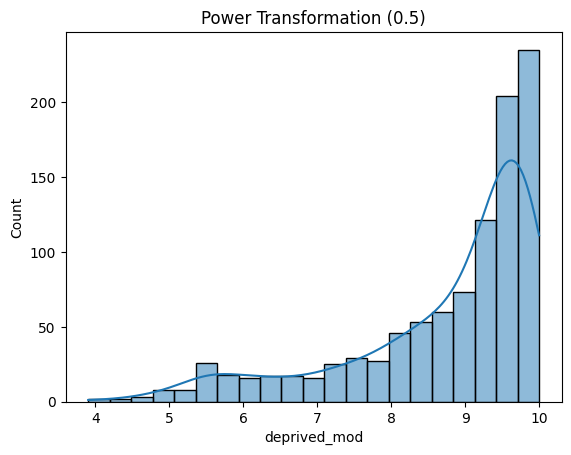

In [13]:
# Power transformation (raising to the power of 0.5)
power_transformed = np.power(merged['deprived_mod'], 0.5)

# Plot the transformed data
sns.histplot(power_transformed, kde=True)
plt.title("Power Transformation (0.5)")
plt.show()

# Boxcox

Lambda: 2.69351856995555


/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 0, 'Transformed data')

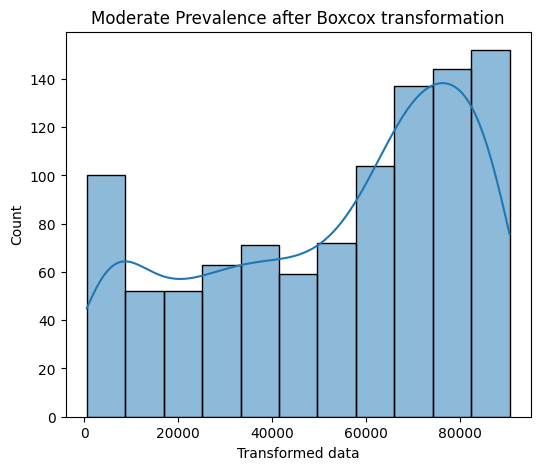

In [222]:
# Box-Cox transformation
boxcox_transformed, lmbda = stats.boxcox(merged_clean['deprived_mod'])
print(f'Lambda: {lmbda}')

merged_clean['deprived_mod_bc'] = boxcox_transformed

# Plot the transformed data
fig, ax = plt.subplots(figsize=(6, 5)) #, dpi=200)

sns.histplot(boxcox_transformed, kde=True)
plt.title('Moderate Prevalence after Boxcox transformation')
plt.xlabel('Transformed data')

In [22]:
import scipy


<Axes: xlabel='deprived_mod_bc', ylabel='Count'>

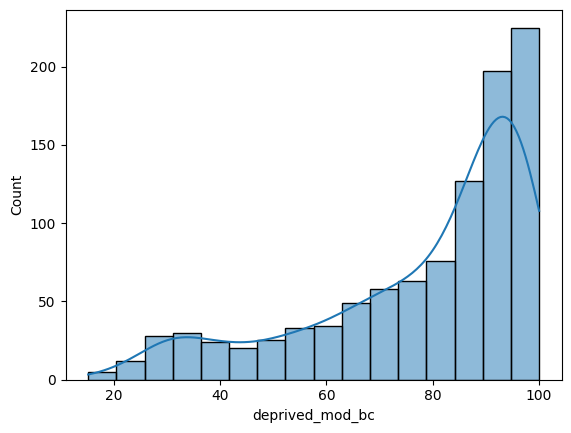

In [58]:
retransformed = scipy.special.inv_boxcox(merged_clean['deprived_mod_bc'], lmbda)
sns.histplot(retransformed, kde=True)

# Oversampling

In [124]:
from tqdm import tqdm

def oversample_to_uniform_distribution(df, target_column='y', num_bins=5):
    # Calculate the desired number of samples in each bin (same as the majority bin)
    hist, bin_edges = np.histogram(df[target_column], bins=num_bins)
    majority_bin_count = np.max(hist)
    bin_counts = [majority_bin_count] * num_bins

    # Create a new DataFrame to store the oversampled data
    df_augmented = pd.DataFrame(columns=df.columns)

    # Oversample each bin
    for i in tqdm(range(num_bins)):
        # Extract data points in the current bin
        bin_start, bin_end = bin_edges[i], bin_edges[i + 1]
        bin_data = df[(df[target_column] >= bin_start) & (df[target_column] < bin_end)]

        # Oversample the bin to match the majority bin count
        oversampled_bin = bin_data.sample(bin_counts[i], replace=True, random_state=42)

        # Append the oversampled data to the new DataFrame
        df_augmented = pd.concat([df_augmented, pd.DataFrame(oversampled_bin)], ignore_index=True)

    return df_augmented

In [125]:
merged_clean = merged.dropna(subset=['deprived_mod'])

np.array(merged_clean['deprived_mod']).min()

15.225185

100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


(3450,)


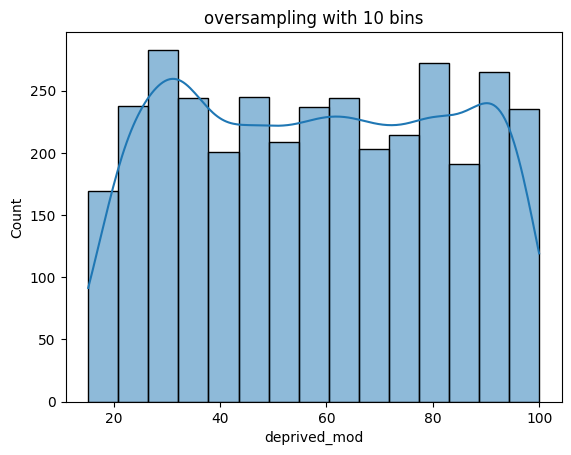

In [126]:
oversampled = oversample_to_uniform_distribution(merged_clean, target_column='deprived_mod', num_bins=10)['deprived_mod']

print(oversampled.shape)

# Plot the transformed data
sns.histplot(oversampled, kde=True)
plt.title("oversampling with 10 bins")
plt.show()

# Discretizing into Classes

In [210]:
num_bins = 20

# Create the bin edges
bin_edges = pd.cut(merged_clean['deprived_mod'], bins=num_bins, labels=False)

# Assign the bin labels to the data
merged_clean['class_label'] = bin_edges

/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


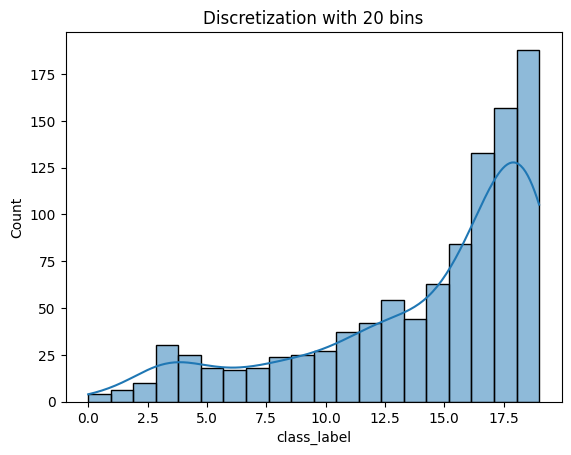

In [213]:
sns.histplot(merged_clean['class_label'], kde=True, bins=20)
plt.title(f"Discretization with {num_bins} bins")
plt.show()

# Classification

In [217]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [221]:
# Split the data into training and testing sets
X = merged_clean[c.mosaiks_features]
y = merged_clean['class_label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose a classification algorithm (example: Logistic Regression)
classifier = LogisticRegression()

# Train the classification model
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.22277227722772278
Precision: 0.21055294945341843
Recall: 0.22277227722772278
F1-score: 0.19739407772521714


/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# PCA

In [223]:
from sklearn.decomposition import PCA



# Create a PCA instance and specify the number of components or variance to retain
pca = PCA(n_components=400)  # Example: Reduce to 2 components

# Fit the PCA model to your standardized data
pca.fit(merged_clean[c.mosaiks_features])

# Transform the data to the first two principal components
X_pca = pca.transform(merged_clean[c.mosaiks_features])


# Training a model just on IRQ

In [311]:
irq_adm1 = merged_clean[merged_clean['countrycode']=='IRQ'].copy()
print(irq_adm1.shape)
irq_adm1['deprived_mod'].describe()

(18, 4040)


count    18.000000
mean     73.126146
std       8.231372
min      51.395329
25%      68.698382
50%      75.273170
75%      77.188135
max      86.324516
Name: deprived_mod, dtype: float64

In [316]:
target = 'deprived_mod'

merged_train_irq, merged_test_irq = train_test_split(irq_adm1, test_size=0.2, random_state=60)

X_train_irq, y_train_irq = merged_train_irq[c.mosaiks_features], merged_train_irq[target]
X_test_irq, y_test_irq = merged_test_irq[c.mosaiks_features], merged_test_irq[target]

In [343]:
merged_train_irq['is_training'] = 1
merged_test_irq['is_training'] = 0

irq_adm1 = pd.concat([merged_train_irq, merged_test_irq]).reset_index(drop=True)

In [320]:
# CROSS VALIDATION

# Initialize the Lasso regression model
# model = Lasso(alpha=0.03) 
# model = LinearRegression()
model = Ridge(alpha=0.1)
# model = KernelRidge()
# model = LinearRegression()
# model = ElasticNet(0.3)
# model = SVR(C=0.5)
# model = SVR(C=0.01)

# Fit the model using K-fold cross-validation on the training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)  

scores = cross_val_score(model, X_train_irq, y_train_irq, cv=kf, scoring = 'r2')
y_train_pred = cross_val_predict(model, X_train, y_train, cv=kf)

print("%0.2f R2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# Fit the model to the entire training data
model.fit(X_train_irq, y_train_irq)
y_train_pred_irq = model.predict(X_train_irq)

# Make predictions on the test data
y_test_pred_irq = model.predict(X_test_irq)

# Evaluate the model's performance
mse = mean_squared_error(y_test_irq, y_test_pred_irq)
r2 = r2_score(y_test_irq, y_test_pred_irq)

# Calculate mean squared error and R-squared on the training data
mse_train = mean_squared_error(y_train_irq, y_train_pred_irq)
r2_train = r2_score(y_train_irq, y_train_pred_irq)


print(f"Training Mean Squared Error: {mse_train:.2f}")
print(f"Training R-squared: {r2_train:.2f}")
print()
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

-2.71 R2 with a standard deviation of 3.43
Training Mean Squared Error: 9.51
Training R-squared: 0.87

Mean Squared Error: 36.97
R-squared: -0.38


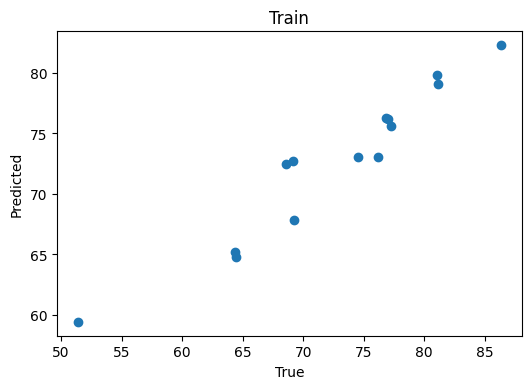

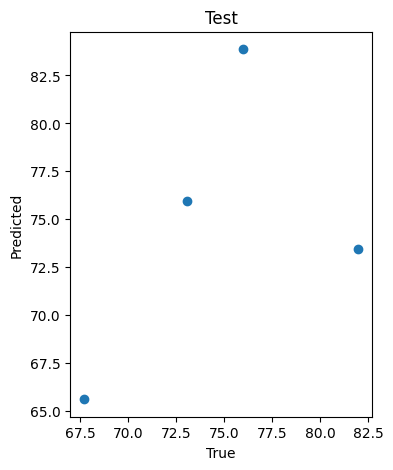

In [351]:
fig, ax = plt.subplots(figsize=(6,5)) #, dpi=200)
ax.scatter(y_train_irq, y_train_pred_irq)
plt.title('Train')
plt.xlabel('True')
plt.ylabel('Predicted')
ax.set_aspect('equal')
plt.show()

fig, ax = plt.subplots(figsize=(6,5)) #, dpi=200)
ax.scatter(y_test_irq, y_test_pred_irq)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Test')
ax.set_aspect('equal')
plt.show()


In [349]:
error_max = 30

In [323]:
irq_adm1['predictions'] = model.predict(irq_adm1[c.mosaiks_features])

irq_adm1['target_error'] = irq_adm1['deprived_mod']-irq_adm1['predictions']


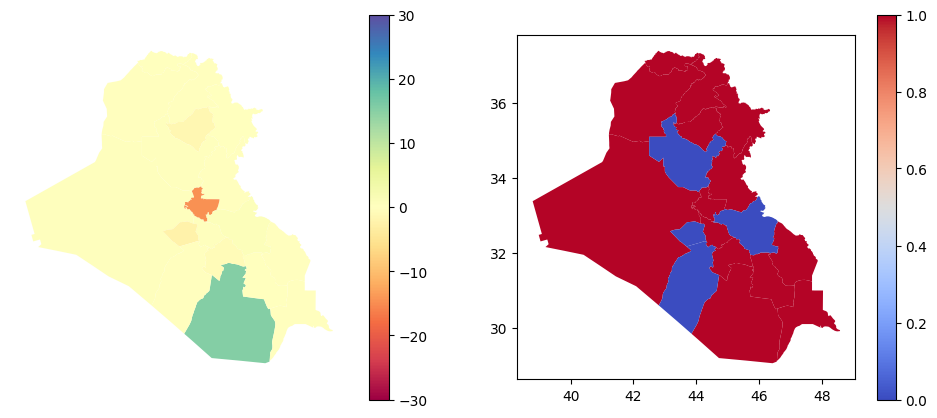

In [350]:
# Create a plot using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot countries with ADM1 error poverty estimates
irq_adm1.plot(ax=ax[0], column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)
# tmp[tmp['countrycode']=='IRQ'].plot(ax=ax, column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)

# ax[0].title('Iraq ADM1 Errors of Moderate Prevalence')
ax[0].axis('off')

irq_adm1.plot(ax=ax[1], column='is_training', cmap = 'coolwarm', legend=True)


plt.show()


# Add Weights

In [281]:
# merged_clean['is_irq'] = np.where(merged_clean['countrycode'] == 'IRQ', 10, 1)

/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Linear Regression

In [12]:
# Get country shapes
geom_adm0 = ld.get_mosaiks_geom_adm0()


The file '../data/external/geoBoundariesCGAZ_ADM0.topojson' exists.


In [282]:
target = 'deprived_mod_bc'

merged_train, merged_test = train_test_split(merged_clean, test_size=0.2, random_state=60)

X_train, y_train = merged_train[c.mosaiks_features], merged_train[target]
X_test, y_test = merged_test[c.mosaiks_features], merged_test[target]

In [283]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [284]:
sample_weights_train = np.where(merged_train['countrycode'] == 'IRQ', 1000, 1)

In [138]:
# print(merged_train[merged_train['countrycode']=='IRQ'].shape)
# print(merged_test[merged_test['countrycode']=='IRQ'].shape)

# fig, ax = plt.subplots()

# merged_train[merged_train['countrycode']=='IRQ'].plot(ax=ax, color='red', label ='train')
# merged_test[merged_test['countrycode']=='IRQ'].plot(ax=ax, color='blue', label ='test')
# plt.legend()
# plt.show()

In [125]:
# merged_train, merged_test = train_test_split(merged_clean, test_size=0.2, random_state=42)

# merged_train_over = oversample_to_uniform_distribution(merged_train, target_column='deprived_mod', num_bins=10)
# merged_test_over = oversample_to_uniform_distribution(merged_test, target_column='deprived_mod', num_bins=10)

# X_train, y_train = merged_train_over[c.mosaiks_features], merged_train_over[target]
# X_test_over, y_test_over = merged_test_over[c.mosaiks_features], merged_test_over[target]
# X_test, y_test = merged_test[c.mosaiks_features], merged_test[target]

In [286]:
# CROSS VALIDATION

# Initialize the Lasso regression model
# model = Lasso(alpha=0.03) 
# model = LinearRegression()
model = Ridge(alpha=0.1)
# model = KernelRidge()
# model = LinearRegression()
# model = ElasticNet(0.3)
# model = SVR(C=0.5)
# model = SVR(C=0.01)

# Fit the model using K-fold cross-validation on the training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)  

scores = cross_val_score(model, X_train, y_train, cv=kf, scoring = 'r2')
# y_train_pred = cross_val_predict(model, X_train, y_train, cv=kf)

print("%0.2f R2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# Fit the model to the entire training data
model.fit(X_train, y_train, sample_weight=sample_weights_train)
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Calculate mean squared error and R-squared on the training data
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)


print(f"Training Mean Squared Error: {mse_train:.2f}")
print(f"Training R-squared: {r2_train:.2f}")
print()
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

0.59 R2 with a standard deviation of 0.07
Training Mean Squared Error: 226395291.30
Training R-squared: 0.68

Mean Squared Error: 310129106.00
R-squared: 0.63


In [287]:
y_train_pred= scipy.special.inv_boxcox(y_train_pred, lmbda)
y_train = scipy.special.inv_boxcox(y_train, lmbda)

y_test = scipy.special.inv_boxcox(y_test, lmbda)
y_test_pred = scipy.special.inv_boxcox(y_test_pred, lmbda)

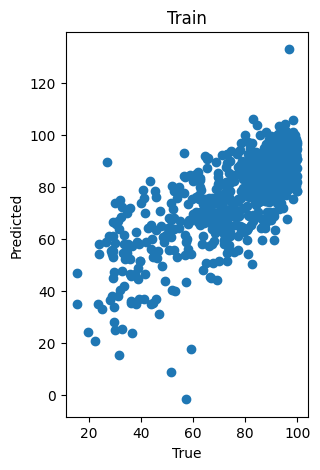

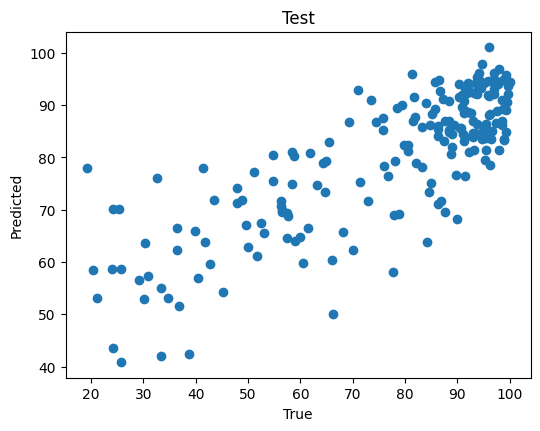

In [352]:
fig, ax = plt.subplots(figsize=(6,5)) #, dpi=200)
ax.scatter(y_train, y_train_pred)
plt.title('Train')
plt.xlabel('True')
plt.ylabel('Predicted')
ax.set_aspect('equal')
plt.show()

fig, ax = plt.subplots(figsize=(6,5)) #, dpi=200)
ax.scatter(y_test, y_test_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Test')
ax.set_aspect('equal')
plt.show()


/home/marina/miniconda3/envs/unicef_iraq/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


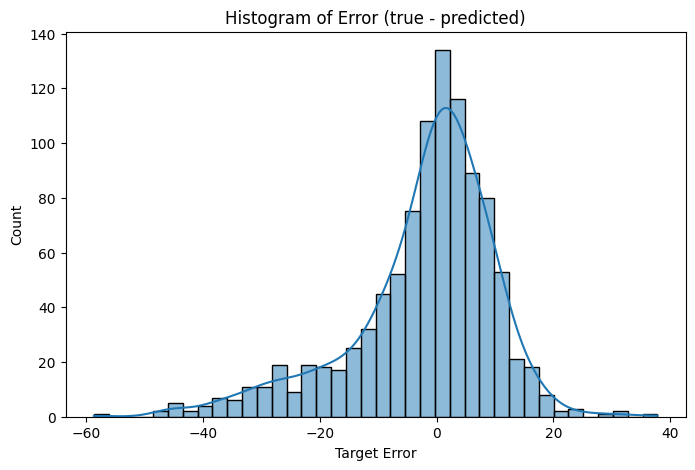

In [289]:
inpt = pca.transform(merged_clean[c.mosaiks_features])
# inpt = merged_clean[c.mosaiks_features]

# merged_clean['predictions'] = model.predict(pca.transform(inpt)

merged_clean['predictions_bc'] = model.predict(inpt)
merged_clean['predictions'] = scipy.special.inv_boxcox(merged_clean['predictions_bc'], lmbda)

merged_clean['target_error'] = merged_clean['deprived_mod']-merged_clean['predictions']

fig, ax = plt.subplots(figsize=(8,5)) #, dpi=200)
sns.histplot(merged_clean['target_error'], kde=True, ax=ax)
plt.xlabel('Target Error')
plt.title('Histogram of Error (true - predicted)')
plt.show()

In [290]:
error_max = abs(merged_clean['target_error']).max()

error_max 

58.690524622807935

In [100]:
# # Create a plot using matplotlib
# fig, ax = plt.subplots(figsize=(13, 5)) #, dpi=200)

# # Plot world countries
# geom_adm0[geom_adm0['shapeName']!='Antarctica'].plot(ax=ax, color= '#b0afae')

# # Plot countries with national poverty estimates
# # merged.plot(ax=ax, column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)
# merged_clean.plot(ax=ax, column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)

# plt.title(f'ADM1 Errors of Moderate Prevalence')
# plt.axis('off')
# plt.show()


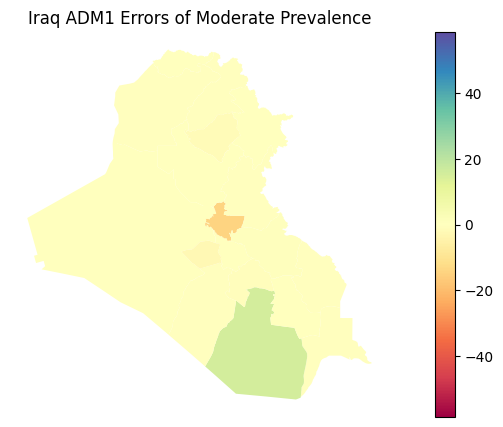

In [291]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5)) #, dpi=200)

# Plot countries with ADM1 error poverty estimates
merged_clean[merged_clean['countrycode']=='IRQ'].plot(ax=ax, column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)
# tmp[tmp['countrycode']=='IRQ'].plot(ax=ax, column='target_error', cmap='Spectral', legend=True, vmin = -error_max, vmax = error_max)

plt.title('Iraq ADM1 Errors of Moderate Prevalence')
plt.axis('off')
plt.show()


In [146]:
# ## Predictions vs True

# # True
# fig, ax = plt.subplots(figsize=(10, 5))
# geom_adm0[geom_adm0['shapeName']!='Antarctica'].plot(ax = ax, color='gray')
# merged_clean.plot(ax = ax, column='deprived_mod', cmap='Purples', legend=True, vmin=0, vmax=100)
# ax.set_title('True')
# ax.axis('off')
# plt.show()

# # Predicted
# fig, ax = plt.subplots(figsize=(10, 5))
# geom_adm0[geom_adm0['shapeName']!='Antarctica'].plot(ax = ax, color='gray')
# merged_clean.plot(ax= ax, column='predictions', cmap='Purples', legend=True, vmin=0, vmax=100)
# ax.set_title('Predicted')
# ax.axis('off')
# plt.show()


# IRQ ADM2

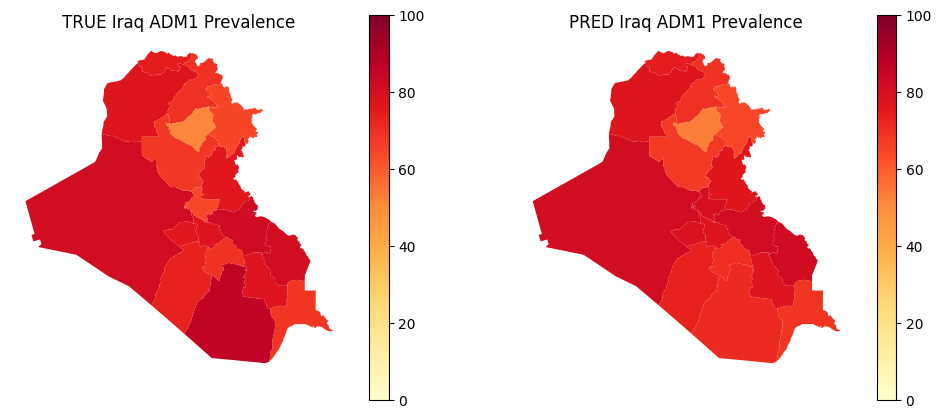

In [292]:
# Predicted
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

merged_clean[merged_clean['countrycode']=='IRQ'].plot(ax= ax[0], column='deprived_mod', cmap='YlOrRd', legend=True, vmin=0, vmax=100)
ax[0].set_title('TRUE Iraq ADM1 Prevalence')
ax[0].axis('off')


merged_clean[merged_clean['countrycode']=='IRQ'].plot(ax= ax[1], column='predictions', cmap='YlOrRd', legend=True, vmin=0, vmax=100)
# tmp[tmp['countrycode']=='IRQ'].plot(ax= ax[1], column='predictions', cmap='Purples', legend=True, vmin = 0, vmax= 100)
ax[1].set_title('PRED Iraq ADM1 Prevalence')
ax[1].axis('off')
plt.show()

In [295]:
inpt_adm2 = pca.transform(irq_adm2[c.mosaiks_features])
# inpt_adm2 = irq_adm2[c.mosaiks_features]

# irq_adm2['predictions'] = model.predict(inpt_adm2)

irq_adm2['predictions_bc'] = model.predict(inpt_adm2)
irq_adm2['predictions'] = scipy.special.inv_boxcox(irq_adm2['predictions_bc'], lmbda)


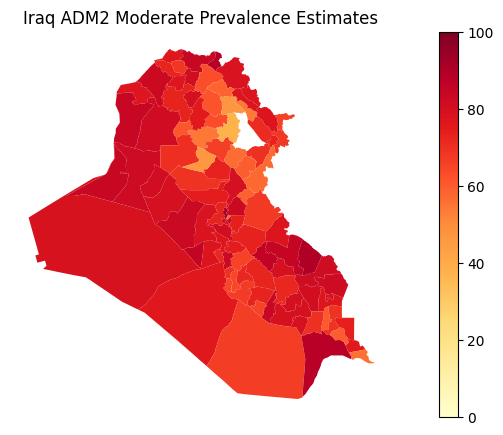

In [297]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5)) #, dpi=200)

# Plot ADM2 prevalence estimate
irq_adm2.plot(ax=ax, column='predictions', cmap='YlOrRd', legend=True, vmin = 0, vmax= 100)

plt.title(f'Iraq ADM2 Moderate Prevalence Estimates')
plt.axis('off')
plt.show()


In [298]:
irq_adm2['predictions'].describe()

count    100.000000
mean      72.864742
std       10.170752
min       37.698990
25%       66.955902
50%       74.571745
75%       80.220746
max       90.570883
Name: predictions, dtype: float64

In [274]:
irq_adm2[['shapeID', 'geometry', 'predictions']].rename(columns={'predictions':'deprived_mod_pred'}).to_csv('../data/processed/results/20230928_irq_adm2_dep_mod.csv', index=False)

# IRQ 01x01

In [305]:
# Select PCA
inpt_01x01 = pca.transform(irq_01x01[c.mosaiks_features])
# inpt_01x01 = irq_01x01[c.mosaiks_features]

# Select BoxCox
# irq_01x01['predictions'] = model.predict(inpt_01x01)

irq_01x01['predictions_bc'] = model.predict(inpt_01x01)
irq_01x01['predictions'] = scipy.special.inv_boxcox(irq_01x01['predictions_bc'], lmbda)

irq_01x01['predictions'].describe()

count    4005.000000
mean       76.467533
std        15.715023
min         6.829354
25%        67.845013
50%        78.835664
75%        87.815641
max       137.842998
Name: predictions, dtype: float64

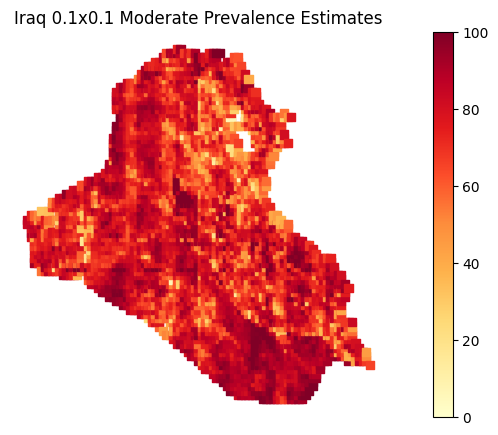

In [306]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5)) #, dpi=200)

# Plot ADM2 prevalence estimate
irq_01x01.plot(ax=ax, column='predictions', cmap='YlOrRd', legend=True, vmin = 0, vmax= 100, marker = ',')

plt.title(f'Iraq 0.1x0.1 Moderate Prevalence Estimates')
plt.axis('off')
plt.show()


In [277]:
# irq_01x01[['lon', 'lat', 'predictions']].rename(columns={'predictions':'deprived_mod_pred'}).to_csv('../data/processed/results/20230928_irq_01x01_dep_mod.csv', index=False)